Neste notebook abordaremo as técnicas:

1. Busca Manual: Definindo hiperparâmetros manualmente;
2. Grid Search: Explorando sistematicamente uma grade de hiperparâmetros;
3. Random Search: Amostrando aleatoriamente hiperparâmetros de distribuições definidas;
4. Otimização Bayesiana (com Hyperopt): Utilizando um método probabilístico para encontrar os melhores hiperparâmetros de forma mais eficiente;
5. Hyperband: Uma estratégia que aloca recursos adaptativamente para explorar um grande espaço de hiperparâmetros.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import time
import hyperopt
from hyperopt import fmin, tpe, hp, Trials
import pandas as pd

In [ ]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**1. Busca Manual**

A busca manual envolve a escolha dos hiperparâmetros com base na intuição, experiência ou tentativa e erro. É simples para um número pequeno de hiperparâmetros e valores, mas se torna impraticável rapidamente à medida que o espaço de busca cresce.

Neste exemplo, testamos duas configurações manualmente definidas.

In [ ]:
# Exemplo com RandomForestClassifier
start_time = time.time()
model_manual_1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_manual_1.fit(X_train, y_train)
y_pred_manual_1 = model_manual_1.predict(X_test)
accuracy_manual_1 = accuracy_score(y_test, y_pred_manual_1)
end_time = time.time()
time_manual_1 = end_time - start_time
print(f"Configuração 1: n_estimators=100, max_depth=10 - Acurácia: {accuracy_manual_1:.4f} - Tempo: {time_manual_1:.2f}s")

start_time = time.time()
model_manual_2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
model_manual_2.fit(X_train, y_train)
y_pred_manual_2 = model_manual_2.predict(X_test)
accuracy_manual_2 = accuracy_score(y_test, y_pred_manual_2)
end_time = time.time()
time_manual_2 = end_time - start_time
print(f"Configuração 2: n_estimators=200, max_depth=20 - Acurácia: {accuracy_manual_2:.4f} - Tempo: {time_manual_2:.2f}s")

--- Manual Search ---
Configuração 1: n_estimators=100, max_depth=10 - Acurácia: 0.8850 - Tempo: 1.10s
Configuração 2: n_estimators=200, max_depth=20 - Acurácia: 0.8900 - Tempo: 1.80s


**2. Grid Search**

O Grid Search explora sistematicamente todas as combinações possíveis de hiperparâmetros dentro de um espaço de busca definido como uma grade. Ele garante que a melhor combinação dentro da grade seja encontrada, mas pode ser computacionalmente caro, especialmente com muitos hiperparâmetros ou valores.

Neste exemplo, definimos uma grade para n_estimators e max_depth. O GridSearchCV avalia cada combinação usando validação cruzada.

In [ ]:
# Definir o espaço de parâmetros para busca
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}

# Criar o modelo base
model = RandomForestClassifier(random_state=42)

# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# Executar o Grid Search
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
time_grid_search = end_time - start_time

print("Melhores parâmetros encontrados (Grid Search):", grid_search.best_params_)
print("Melhor pontuação (Grid Search):", grid_search.best_score_)
print(f"Tempo de execução (Grid Search): {time_grid_search:.2f} segundos")


--- Grid Search ---
Melhores parâmetros encontrados (Grid Search): {'max_depth': 10, 'n_estimators': 50}
Melhor pontuação (Grid Search): 0.8962528042953827
Tempo de execução (Grid Search): 9.91 segundos


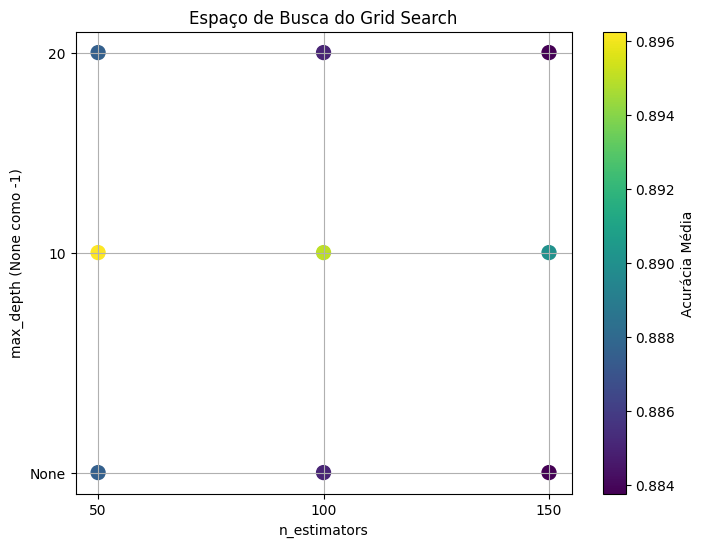

In [ ]:
# Para plotar, vamos extrair os resultados do grid_search
results = grid_search.cv_results_
params = results['params']
mean_test_score = results['mean_test_score']

# Extrair valores dos parâmetros para plotagem
n_estimators_values = [p['n_estimators'] for p in params]
max_depth_values = [p['max_depth'] if p['max_depth'] is not None else -1 for p in params] # Representar None com -1 para plotar

plt.figure(figsize=(8, 6))
scatter = plt.scatter(n_estimators_values, max_depth_values, c=mean_test_score, cmap='viridis', s=100)
plt.colorbar(scatter, label='Acurácia Média')
plt.xlabel('n_estimators')
plt.ylabel('max_depth (None como -1)')
plt.title('Espaço de Busca do Grid Search')
plt.xticks([50, 100, 150])
plt.yticks([-1, 10, 20], ['None', 10, 20])
plt.grid(True)
plt.show()

Visualização do Espaço de Busca do Grid Search:

Este gráfico mostra os pontos avaliados pelo Grid Search no espaço de hiperparâmetros definido (n_estimators vs. max_depth). Cada ponto representa uma combinação específica de hiperparâmetros, e a cor indica a acurácia média obtida através da validação cruzada para essa combinação.

Eixo X (n_estimators): O número de árvores na floresta aleatória.
Eixo Y (max_depth): A profundidade máxima das árvores (representamos None como -1 para fins de plotagem).
Cor: A acurácia média na validação cruzada para cada combinação de hiperparâmetros. Cores mais quentes (geralmente amarelas/brancas no colormap 'viridis') indicam maior acurácia.
Impacto no gráfico:

Cada ponto no gráfico corresponde a uma combinação de hiperparâmetros no param_grid que foi avaliada pelo GridSearchCV.
O gráfico visualmente mostra como a acurácia varia em todo o espaço de busca definido. Podemos identificar regiões no espaço de busca que tendem a ter um desempenho melhor. Ele ilustra a natureza exaustiva do Grid Search, onde todos os pontos da grade são testados.

**3. Random Search**

O Random Search amostra aleatoriamente um número fixo de combinações de hiperparâmetros de distribuições definidas para cada hiperparâmetro. Embora não explore exaustivamente a grade, ele tende a encontrar bons resultados mais rapidamente do que o Grid Search em espaços de busca maiores, pois tem uma chance maior de explorar regiões promissoras que o Grid Search pode ignorar se a grade for muito esparsa.

Definimos distribuições para n_estimators, max_depth, min_samples_split e min_samples_leaf e executamos n_iter iterações.

In [ ]:
# Definir o espaço de parâmetros para busca (distribuições)
param_dist = {
    'n_estimators': [int(x) for x in range(50, 200, 10)],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criar o modelo base
model = RandomForestClassifier(random_state=42)

# Configurar o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', random_state=42)

# Executar o Random Search
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
time_random_search = end_time - start_time

print("Melhores parâmetros encontrados (Random Search):", random_search.best_params_)
print("Melhor pontuação (Random Search):", random_search.best_score_)
print(f"Tempo de execução (Random Search): {time_random_search:.2f} segundos")


--- Random Search ---
Melhores parâmetros encontrados (Random Search): {'n_estimators': 60, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 50}
Melhor pontuação (Random Search): 0.8900059136605559
Tempo de execução (Random Search): 12.60 segundos


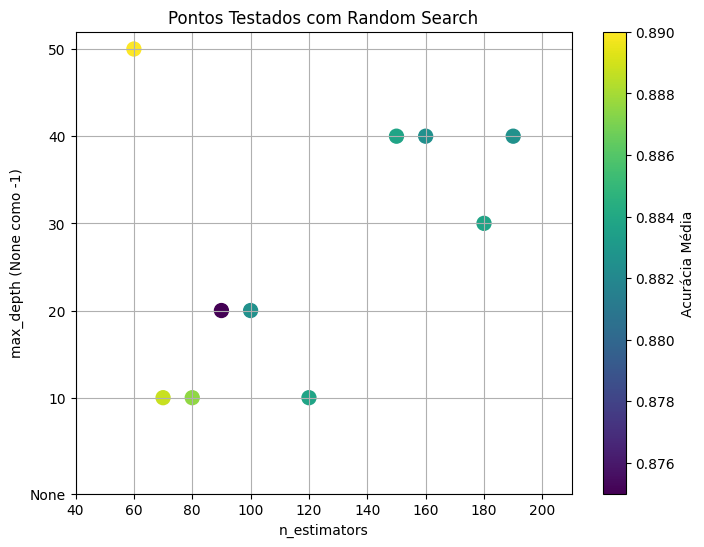

In [ ]:
# Para plotar, vamos extrair os resultados do random_search
results_rand = random_search.cv_results_
params_rand = results_rand['params']
mean_test_score_rand = results_rand['mean_test_score']

# Extrair valores dos parâmetros para plotagem (usando n_estimators e max_depth como exemplo)
n_estimators_values_rand = [p['n_estimators'] for p in params_rand]
max_depth_values_rand = [p['max_depth'] if p['max_depth'] is not None else -1 for p in params_rand]

plt.figure(figsize=(8, 6))
scatter_rand = plt.scatter(n_estimators_values_rand, max_depth_values_rand, c=mean_test_score_rand, cmap='viridis', s=100)
plt.colorbar(scatter_rand, label='Acurácia Média')
plt.xlabel('n_estimators')
plt.ylabel('max_depth (None como -1)')
plt.title('Pontos Testados com Random Search')

# Ajuste os limites dos eixos conforme o espaço de busca definido
plt.xlim(40, 210)
plt.yticks([-1, 10, 20, 30, 40, 50], ['None', 10, 20, 30, 40, 50])
plt.grid(True)
plt.show()

Visualização dos Pontos Testados com Random Search:

Este gráfico similar ao do Grid Search, mas mostra os pontos aleatoriamente amostrados pelo Random Search.

Eixo X (n_estimators) e Eixo Y (max_depth): Os mesmos parâmetros do gráfico anterior, mas aqui os pontos são amostrados de um intervalo em vez de uma grade fixa. Representamos None como -1.
Cor: A acurácia média na validação cruzada para cada configuração aleatória testada.

Impacto no gráfico:
Ao contrário do Grid Search, os pontos não formam uma grade regular. Eles estão espalhados aleatoriamente dentro do espaço de busca definido pelas distribuições de parâmetros.
O gráfico ilustra como o Random Search explora o espaço de busca de forma mais dispersa, o que pode ser eficiente para encontrar boas combinações em espaços de alta dimensão ou com muitos valores possíveis.
Podemos observar as acurácias obtidas em cada ponto amostrado aleatoriamente.


**4. Otimização Bayesiana (com Hyperopt)**

A Otimização Bayesiana é uma abordagem probabilística para otimizar funções objetivas caras de avaliar (como o treinamento e avaliação de um modelo com um conjunto de hiperparâmetros). Ela constrói um modelo probabilístico (geralmente um Processo Gaussiano) da função objetivo e usa esse modelo para decidir qual conjunto de hiperparâmetros testar em seguida, buscando equilibrar a exploração (testar novas áreas do espaço de busca) e a explotação (testar áreas onde o modelo prevê bons resultados).

Usamos a biblioteca hyperopt para implementar a otimização Bayesiana com o algoritmo TPE (Tree-structured Parzen Estimator).


In [ ]:
# Definir a função objetivo a ser minimizada
def objective(params):
    model = RandomForestClassifier(**params, random_state=42)
    # Usar validação cruzada para uma avaliação mais robusta
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    # Retornar a média da acurácia (negativa para minimização)
    return -np.mean(scores)

# Definir o espaço de busca para a Otimização Bayesiana
space = {
    'n_estimators': hp.choice('n_estimators', [int(x) for x in range(50, 200, 10)]),
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30, 40, 50]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4])
}

# Configurar o Hyperopt
trials = Trials()
start_time = time.time()
best_params_bayes = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=20,
                        trials=trials)
end_time = time.time()
time_bayes_opt = end_time - start_time

print("Melhores parâmetros encontrados (Otimização Bayesiana):", best_params_bayes)
# A acurácia é o negativo do valor retornado pela função objetivo com os melhores parâmetros
best_accuracy_bayes = -trials.best_trial['result']['loss']
print("Melhor acurácia (Otimização Bayesiana):", best_accuracy_bayes)
print(f"Tempo de execução (Otimização Bayesiana): {time_bayes_opt:.2f} segundos")


--- Bayesian Optimization ---
100%|██████████| 20/20 [00:27<00:00,  1.36s/trial, best loss: -0.8900106070419495]
Melhores parâmetros encontrados (Otimização Bayesiana): {'max_depth': np.int64(4), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(7)}
Melhor acurácia (Otimização Bayesiana): 0.8900106070419495
Tempo de execução (Otimização Bayesiana): 27.21 segundos


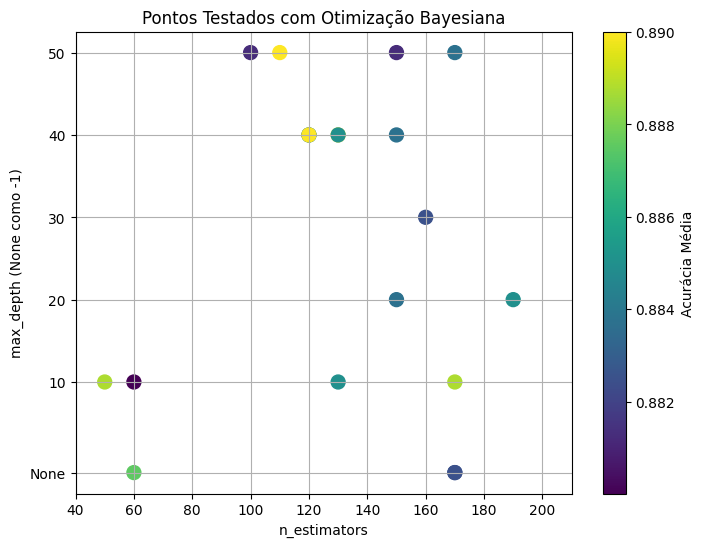

In [ ]:
# Para plotar, vamos extrair os resultados do trials
trial_results = trials.vals
losses = trials.losses()

# Extrair valores dos parâmetros para plotagem (usando n_estimators e max_depth como exemplo)
# Note que os valores em trial_results estão no formato do Hyperopt, precisamos mapeá-los
n_estimators_choices = [int(x) for x in range(50, 200, 10)]
max_depth_choices = [None, 10, 20, 30, 40, 50]

n_estimators_values_bayes = [n_estimators_choices[idx] for idx in trial_results['n_estimators']]
max_depth_values_bayes = [max_depth_choices[idx] if max_depth_choices[idx] is not None else -1 for idx in trial_results['max_depth']]
accuracies_bayes = [-loss for loss in losses] # Converter loss de volta para acurácia

plt.figure(figsize=(8, 6))
scatter_bayes = plt.scatter(n_estimators_values_bayes, max_depth_values_bayes, c=accuracies_bayes, cmap='viridis', s=100)
plt.colorbar(scatter_bayes, label='Acurácia Média')
plt.xlabel('n_estimators')
plt.ylabel('max_depth (None como -1)')
plt.title('Pontos Testados com Otimização Bayesiana')
# Ajuste os limites dos eixos conforme o espaço de busca definido
plt.xlim(40, 210)
plt.yticks([-1, 10, 20, 30, 40, 50], ['None', 10, 20, 30, 40, 50])
plt.grid(True)
plt.show()

Visualização dos Pontos Testados com Otimização Bayesiana:

Este gráfico mostra os pontos do espaço de busca que foram avaliados durante o processo de otimização Bayesiana.

Eixo X (n_estimators) e Eixo Y (max_depth): Os mesmos parâmetros dos gráficos anteriores, representando os valores de hiperparâmetros testados. Representamos None como -1.
Cor: A acurácia média na validação cruzada para cada ponto testado.
Impacto no gráfico:

Observe que, ao contrário do Grid Search, nem todos os pontos possíveis dentro das escolhas definidas são testados.
O algoritmo de Otimização Bayesiana (TPE neste caso) decide inteligentemente quais pontos testar em seguida com base nos resultados das avaliações anteriores. Ele tende a concentrar as avaliações em regiões do espaço de busca que parecem promissoras.
A distribuição dos pontos pode parecer menos "organizada" do que no Grid Search, mas a ideia é que menos avaliações sejam necessárias para encontrar um bom conjunto de hiperparâmetros em comparação com a exploração exaustiva ou totalmente aleatória.

**5. Hyperband (Conceitual)**

Hyperband é um algoritmo de otimização de hiperparâmetros que é particularmente útil quando o tempo de treinamento por configuração varia e é possível treinar modelos com orçamentos menores (por exemplo, menos épocas em redes neurais). Ele não treina todas as configurações candidatas até o final. Em vez disso, ele inicia muitas configurações com um orçamento pequeno e descarta as que têm pior desempenho, promovendo as melhores para serem treinadas com orçamentos maiores em fases subsequentes.

O código abaixo apresenta uma visualização conceitual de como o Hyperband opera, mostrando como diferentes configurações candidatas progridem em diferentes "orçamentos" (representados aqui como etapas de treinamento ou épocas).

--- Gráfico Conceitual de Hyperband ---


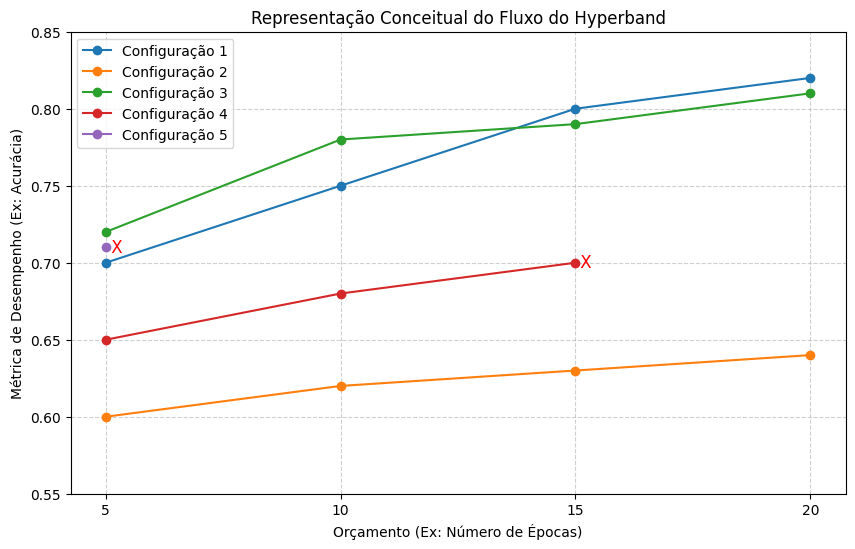

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("--- Gráfico Conceitual de Hyperband ---")

# Simulação de algumas configurações com diferentes performances
# Cada lista representa uma configuração, e os valores são acurácias
# em diferentes "orçamentos" (épocas)
configs_performance = [
    [0.7, 0.75, 0.8, 0.82],  # Config 1: Melhora consistentemente
    [0.6, 0.62, 0.63, 0.64],  # Config 2: Baixo desempenho inicial e melhora pouco
    [0.72, 0.78, 0.79, 0.81], # Config 3: Bom desempenho inicial
    [0.65, 0.68, 0.7, None],  # Config 4: Descartada em um estágio intermediário
    [0.71, None, None, None], # Config 5: Descartada cedo
]

# Orçamentos (épocas)
budgets = [5, 10, 15, 20] # Exemplo: 5, 10, 15 e 20 épocas

plt.figure(figsize=(10, 6))

for i, performance in enumerate(configs_performance):
    # Remove None para plotar apenas os pontos que foram avaliados
    evaluated_budgets = [budgets[j] for j, val in enumerate(performance) if val is not None]
    evaluated_performance = [val for val in performance if val is not None]

    if len(evaluated_budgets) > 0:
        plt.plot(evaluated_budgets, evaluated_performance, marker='o', linestyle='-', label=f'Configuração {i+1}')

        # Adicionar um 'X' onde a configuração foi descartada (se houver)
        if len(evaluated_budgets) < len(budgets):
            last_evaluated_budget = evaluated_budgets[-1]
            last_evaluated_performance = evaluated_performance[-1]
            plt.text(last_evaluated_budget, last_evaluated_performance, ' X', color='red', fontsize=12, va='center')


plt.xlabel('Orçamento (Ex: Número de Épocas)')
plt.ylabel('Métrica de Desempenho (Ex: Acurácia)')
plt.title('Representação Conceitual do Fluxo do Hyperband')
plt.xticks(budgets)
plt.ylim(0.55, 0.85) # Ajuste conforme os valores simulados
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Gráfico Conceitual do Fluxo do Hyperband:

Este gráfico ilustra o conceito central do Hyperband: alocação adaptativa de recursos.

Eixo X (Orçamento): Representa o nível de recursos alocado para treinar uma configuração (por exemplo, número de épocas de treinamento para uma rede neural, ou um subconjunto menor do conjunto de dados).
Eixo Y (Métrica de Desempenho): Representa a performance da configuração com o orçamento alocado (por exemplo, acurácia na validação).
Linhas: Cada linha representa uma configuração candidata sendo avaliada.
Pontos nas linhas: Indicam a performance da configuração em diferentes níveis de orçamento onde ela foi avaliada.
'X' vermelho: Indica o ponto onde uma configuração foi descartada (não continuou sendo treinada com orçamentos maiores) por não apresentar um desempenho promissor em relação a outras configurações no mesmo estágio.
Impacto no gráfico:

O gráfico mostra como o Hyperband inicia com muitas configurações com um orçamento baixo (o início das linhas).
Conforme o orçamento aumenta (movendo-se para a direita no gráfico), menos linhas continuam, indicando que as configurações com pior desempenho foram descartadas.
As configurações que mostram um bom desempenho inicial têm a chance de serem treinadas com orçamentos maiores, potencialmente levando a um desempenho ainda melhor.
Ele destaca a eficiência do Hyperband em evitar o desperdício de recursos treinando configurações ruins até o fim.